In [2]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
using LinearAlgebra
using DoubleFloats

In [3]:
function compile_kernel_array_NS(M)
    @variables x₁ x₂ ϵ u1 v1 u2 v2;
    N1 = size(M)[1]
    N2 = size(M)[2]
    P = Matrix{Function}(undef,N1,N2)
    for i = 1:N1
        for j = 1:N2
            #display(M[i,j])
            P[i,j] = eval(build_function(M[i,j], [x₁, x₂], [u1 v1 u2 v2],ϵ))
        end
    end
    return P
end
function compile_polynomials_NS(M)
    @variables x₁ x₂ ϵ u1 v1;
    N1 = size(M)[1]
    N2 = size(M)[2]
    P = Matrix{Function}(undef,N1,N2)
    for i = 1:N1
        for j = 1:N2
            #display(M[i,j])
            P[i,j] = eval(build_function(M[i,j], [x₁, x₂],[u1,v1]))
        end
    end
    return P
end
μ = 1
ρ = 1
@variables ϵ r x₁ x₂ u1 v1 u2 v2 ;
ϕ1 = r^7
ϕ2 = r^3

ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2))
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2))

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1x(x) =  -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])  #+  u1*∂₁(x[1]) + v1*∂₂(x[1])
λ2x(x) =  -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3]) #+ u1*∂₁(x[2]) + v1*∂₂(x[2])
λ3x(x) = x[1]
λ4x(x) = x[2]

λ1y(x) =  -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3]) #- u2*∂₁(x[1]) - v2*∂₂(x[1])
λ2y(x) =  -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3]) #-u2*∂₁(x[2]) - v2*∂₂(x[2])
λ3y(x) = x[1]
λ4y(x) = x[2]

display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
display(F_A)
F_A = compile_kernel_array_NS(F_A)
F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
display(F_B)
F_B = compile_kernel_array_NS(F_B)

P_list2D = generate_2D2_div_free_poly_basis(4)
P_list1D = generate_2D1_poly_basis(2)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
#display(P_list)

F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)
display(F_PA)
F_PA = compile_polynomials_NS(F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
display(F_PB)
F_PB = compile_polynomials_NS(F_PB)

N_poly = size(F_PA)[2]

println("done")
F_A

3×3 Matrix{Num}:
 (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                                  (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                                    0     sqrt(x₁^2 + x₂^2)^3

6×6 Matrix{Num}:
 (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)                                                                                                                                                                          …                                   (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)
                                  (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                                                                                                                                                                             (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₁^2)*(sqrt(x₁^2 + x₂^2)^3)
                                                                  140.0(sqrt(x₁^2 + x₂^2)^3) + 105.0(x₂^4)*(sqrt(x₁^2 + x₂^2)^-1) + 105.0(x₁^2)*sqrt(x₁^2 + x₂^2) + 735.0(x₂^2)*sqrt(x₁^2 + x₂^2) + 105.0(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)                                                                     -105.0x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1) - 630.0x₁*x₂*sqr

2×6 Matrix{Num}:
  140.0(sqrt(x₁^2 + x₂^2)^3) + 105.0(x₂^4)*(sqrt(x₁^2 + x₂^2)^-1) + 105.0(x₁^2)*sqrt(x₁^2 + x₂^2) + 735.0(x₂^2)*sqrt(x₁^2 + x₂^2) + 105.0(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)  …  -105.0x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1) - 630.0x₁*x₂*sqrt(x₁^2 + x₂^2) - 105.0x₂*(x₁^3)*(sqrt(x₁^2 + x₂^2)^-1)
 -105.0x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1) - 630.0x₁*x₂*sqrt(x₁^2 + x₂^2) - 105.0x₂*(x₁^3)*(sqrt(x₁^2 + x₂^2)^-1)                                                                     140.0(sqrt(x₁^2 + x₂^2)^3) + 105.0(x₁^4)*(sqrt(x₁^2 + x₂^2)^-1) + 105.0(x₂^2)*sqrt(x₁^2 + x₂^2) + 735.0(x₁^2)*sqrt(x₁^2 + x₂^2) + 105.0(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)

6×25 Matrix{Num}:
 1    x₂     x₁    x₂^2             x₁*x₂    …  0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)       0.0  0.0    0.0   0.0    0.0
 0.0   0.0    0.0    -2.0               0.0     0.0  1.0    0.0  x₂    2x₁
 0.0   0.0    0.0     0.0               1.0     1.0  0.0  2x₂    x₁      0.0
 1    x₂     x₁    x₂^2             x₁*x₂       0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0  (-1//2)*(x₂^2)    …  0.0  0.0    0.0   0.0    0.0

2×25 Matrix{Num}:
 0.0  0.0  0.0  -2.0  0.0  -2.0  -6.0x₂  …  0.0  1.0    0.0  x₂  2x₁
 0.0  0.0  0.0   0.0  1.0   0.0   0.0       1.0  0.0  2x₂    x₁    0.0

done


6×6 Matrix{Function}:
 #14  #16  #18  #20  #22  #24
 #26  #28  #30  #32  #34  #36
 #38  #40  #42  #44  #46  #48
 #50  #52  #54  #56  #58  #60
 #62  #64  #66  #68  #70  #72
 #74  #76  #78  #80  #82  #84

total number of nodes: 400
number of internal_nodes: 324
 number of top nodes: 20
number of side nodes: 56


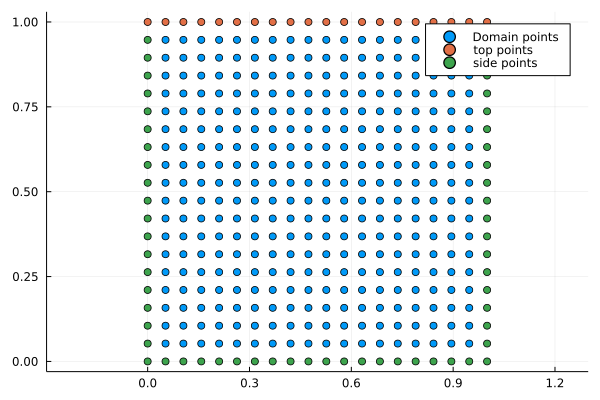

In [4]:
#generate points for lid_driven_cavity
N_side = 20
I_points,B_points =  generate_2D_equally_spaced_points(N_side)
N_I = size(I_points)[2]
N_B = size(B_points)[2]
N = N_I + N_B
top_points= zeros((2,1+Int(N_B/4)))
side_points = zeros((2,N_B-size(top_points)[2]))
s1,s2 = 1,1
for i in 1:N_B
    if B_points[2,i] == 1.0
        top_points[:,s1] = B_points[:,i]
        s1+=1
    else
        side_points[:,s2] = B_points[:,i]
        s2+=1
    end
end
B_points = hcat(top_points,side_points)
All_points = hcat(I_points,B_points)

N_top = size(top_points)[2]
N_walls = size(side_points)[2]
println("total number of nodes: ",N)
println("number of internal_nodes: ",N_I)
println(" number of top nodes: ",N_top)
println("number of side nodes: ",N_walls)
Plots.scatter(I_points[1,:],I_points[2,:],aspect_ratio=:equal,label = "Domain points")
Plots.scatter!(top_points[1,:],top_points[2,:],aspect_ratio=:equal,label ="top points")
Plots.scatter!(side_points[1,:],side_points[2,:],aspect_ratio=:equal,label ="side points")
#savefig("internal_domain_points.png")

In [9]:
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))

u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)

u = 20*x*y^3
v =  0 #5*x^4 - 5*y^4
p = 60*x*x*y - 20*y*y*y 

#display(dx(u)+dy(v))
f1 = 0.0#-dx(dx(u)) - dy(dy(u)) + dx(p) +0.0
f2 = 0.0#-dx(dx(v)) - dy(dy(v)) + dy(p) +0.0
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y))
f2 = eval(build_function(f2,x,y))
#true_v1(x,y) = eval(build_function(u,x,y))(x,y)
#true_v2(x,y) = eval(build_function(v,x,y))(x,y)
true_v1(x,y) = Float64(Int(y>0.999))
true_v2(x,y) = 0.0
f1(12.0,2.7)
true_v1(1,1)

0.0

0.0

1.0

In [17]:
# assemble matrices and rhs 

function apply_NS(p1,p2,u1,v1,u2,v2,f,param)
    d1 = size(p1)[2]
    d2 = size(p2)[2]
    M = zeros(d1,d2)
    if (d1 != length(u1)) || (d1 !=length(v1)) || (d2 != length(u2)) || (d2 !=length(v2))
        error("velocity and point arrays have  different sizes ")
    end
    for i in 1:d1
        for j in 1:d2
            a = p1[:,i]-p2[:,j]
            
            a = (abs.(a) .< [1e-60,1e-60])*1e-60 .+ a
            #println(a)
            M[i,j] = f(a,[u1[i] v1[i] u2[j] v2[j]],ϵ)
        end
    end
    return M
end

function apply_P_NS(p,u,v,fp_array)
    d1 = size(p)[2]
    d2 = length(fp_array)
    if (d1 != length(u)) || (d1 !=length(v))
        error("velocity and point arrays have  different sizes ")
    end
    res = zeros(d1,d2)
    for i in 1:d1
        for j in 1:d2
            res[i,j] = fp_array[j](p[:,i],[u[i],v[i]])
        end
    end
    return res
end
gu = zeros(N_B)
gu[1:N_top] .= -1.0
gv = zeros(N_B)

U = zeros(2*N_I)
param = 5
r = 2.01*1.45/(N_side-1)
I_tree = KDTree(I_points,Euclidean(),leafsize = 3)
B_tree = KDTree(B_points,Euclidean(),leafsize = 3)
G = zeros(2*N_I,2*N_I) # global sprse matrix 
#Global_RHS = zeros(2*N_I)
Global_RHS = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
cond_num_array = zeros(N_I)
for i in 1:N_I
    I_idx = inrange(I_tree, I_points[:,i], r, true)
    I_idx = deleteat!(I_idx,findall(x->x==i,I_idx))
    B_idx = inrange(B_tree, I_points[:,i], r, true)
    Local_B_points = B_points[:,B_idx] .- reshape(I_points[:,i],(2,1))
    Local_I_points = I_points[:,I_idx] .- reshape(I_points[:,i],(2,1))
    #display(Local_I_points)
    Full_Local_I_points = hcat(I_points[:,i],I_points[:,I_idx]) .- reshape(I_points[:,i],(2,1))# internal points including center 
    N_I_local = length(I_idx)+1 # total number of local points 
    #display(Full_Local_I_points)
    default_point_list = [Full_Local_I_points,Full_Local_I_points,Local_I_points,Local_I_points] # list of points if no boundary is present
    sample_point_list = [reshape([0.0,0.0],(2,1)),reshape([0.0,0.0],(2,1))]
    u_loc_full =  vcat(U[i],U[I_idx])
    v_loc_full =  vcat(U[i+N_I],U[I_idx .+ N_I])
    u_loc      =  U[I_idx]
    v_loc      =  U[I_idx .+ N_I]

    A11 = apply_NS(Full_Local_I_points,Full_Local_I_points,u_loc_full,v_loc_full,u_loc_full,v_loc_full,F_A[1,1],param)
    A12 = apply_NS(Full_Local_I_points,Full_Local_I_points,u_loc_full,v_loc_full,u_loc_full,v_loc_full,F_A[1,2],param)
    A13 = apply_NS(Full_Local_I_points,Local_I_points,u_loc_full,v_loc_full,u_loc,v_loc,F_A[1,3],param)
    A14 = apply_NS(Full_Local_I_points,Local_I_points,u_loc_full,v_loc_full,u_loc,v_loc,F_A[1,4],param)

    A22 = apply_NS(Full_Local_I_points,Full_Local_I_points,u_loc_full,v_loc_full,u_loc_full,v_loc_full,F_A[2,2],param)
    A23 = apply_NS(Full_Local_I_points,Local_I_points,u_loc_full,v_loc_full,u_loc,v_loc,F_A[2,3],param)
    A24 = apply_NS(Full_Local_I_points,Local_I_points,u_loc_full,v_loc_full,u_loc,v_loc,F_A[2,4],param)

    A33 = apply_NS(Local_I_points,Local_I_points,u_loc,v_loc,u_loc,v_loc,F_A[3,3],param)
    A34 = apply_NS(Local_I_points,Local_I_points,u_loc,v_loc,u_loc,v_loc,F_A[3,4],param)

    A44 = apply_NS(Local_I_points,Local_I_points,u_loc,v_loc,u_loc,v_loc,F_A[4,4],param)

    P1 = apply_P_NS(Full_Local_I_points,u_loc_full,v_loc_full,F_PA[1,:])
    P2 = apply_P_NS(Full_Local_I_points,u_loc_full,v_loc_full,F_PA[2,:])
    P3 = apply_P_NS(Local_I_points,u_loc,v_loc,F_PA[3,:])
    P4 = apply_P_NS(Local_I_points,u_loc,v_loc,F_PA[4,:])

    PB1 = apply_P_NS(reshape([0.0,0.0],(2,1)),[U[i]],[U[i+N_I]],F_PB[1,:])
    PB2 = apply_P_NS(reshape([0.0,0.0],(2,1)),[U[i]],[U[i+N_I]],F_PB[2,:])
    B11 = apply_NS(reshape([0.0,0.0],(2,1)),Full_Local_I_points,[U[i]],U[i+N_I],u_loc_full,v_loc_full,F_B[1,1],param)
    B12 = apply_NS(reshape([0.0,0.0],(2,1)),Full_Local_I_points,[U[i]],U[i+N_I],u_loc_full,v_loc_full,F_B[1,2],param)

    B13 = apply_NS(reshape([0.0,0.0],(2,1)),Local_I_points,[U[i]],U[i+N_I],u_loc,v_loc,F_B[1,3],param)
    B14 = apply_NS(reshape([0.0,0.0],(2,1)),Local_I_points,[U[i]],U[i+N_I],u_loc,v_loc,F_B[1,4],param)

    B21 = apply_NS(reshape([0.0,0.0],(2,1)),Full_Local_I_points,[U[i]],U[i+N_I],u_loc_full,v_loc_full,F_B[2,1],param)
    B22 = apply_NS(reshape([0.0,0.0],(2,1)),Full_Local_I_points,[U[i]],U[i+N_I],u_loc_full,v_loc_full,F_B[2,2],param)
    B23 = apply_NS(reshape([0.0,0.0],(2,1)),Local_I_points,[U[i]],U[i+N_I],u_loc,v_loc,F_B[2,3],param)
    B24 = apply_NS(reshape([0.0,0.0],(2,1)),Local_I_points,[U[i]],U[i+N_I],u_loc,v_loc,F_B[2,4],param)

    #display(B11)
    #L_RHS = zeros(2*N_I_local-2)
    L_RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]))
    if isempty(B_idx)

        #println(size(A11))
        #println(size(P1))
        RHS = vcat(L_RHS,zeros(N_poly))
        A = [A11 A12 A13 A14 P1;
        A12' A22 A23 A24 P2;
        A13' A23' A33 A34 P3;
        A14' A24' A34' A44 P4;
        P1' P2' P3' P4' zeros(N_poly,N_poly)]
        #display(cond(A))
        B = [B11 B12 B13 B14 PB1;
             B21 B22 B23 B24 PB2]

    else
        # present bc
        RHS = vcat(L_RHS,true_v1.(B_points[1,B_idx],B_points[2,B_idx]),true_v2.(B_points[1,B_idx],B_points[2,B_idx])
        ,zeros(N_poly))
        #RHS = vcat(L_RHS,gu[B_idx],gv[B_idx],zeros(N_poly))
        display(RHS[length(L_RHS)+1:end-N_poly])
        zero_u = zeros(length(B_idx))
        A15 = apply_NS(Full_Local_I_points,Local_B_points,u_loc_full,v_loc_full,zero_u,zero_u,F_A[1,5],param)
        A16 = apply_NS(Full_Local_I_points,Local_B_points,u_loc_full,v_loc_full,zero_u,zero_u,F_A[1,6],param)
        A25 = apply_NS(Full_Local_I_points,Local_B_points,u_loc_full,v_loc_full,zero_u,zero_u,F_A[2,5],param)
        A26 = apply_NS(Full_Local_I_points,Local_B_points,u_loc_full,v_loc_full,zero_u,zero_u,F_A[2,6],param)

        A35 = apply_NS(Local_I_points,Local_B_points,u_loc,v_loc,zero_u,zero_u,F_A[3,5],param)
        A36 = apply_NS(Local_I_points,Local_B_points,u_loc,v_loc,zero_u,zero_u,F_A[3,6],param)
        A45 = apply_NS(Local_I_points,Local_B_points,u_loc,v_loc,zero_u,zero_u,F_A[4,5],param)
        A46 = apply_NS(Local_I_points,Local_B_points,u_loc,v_loc,zero_u,zero_u,F_A[4,6],param)

        A55 = apply_NS(Local_B_points,Local_B_points,zero_u,zero_u,zero_u,zero_u,F_A[5,5],param)
        A56 = apply_NS(Local_B_points,Local_B_points,zero_u,zero_u,zero_u,zero_u,F_A[5,6],param)
        A66 = apply_NS(Local_B_points,Local_B_points,zero_u,zero_u,zero_u,zero_u,F_A[6,6],param)

        P5 = apply_P_NS(Local_B_points,zero_u,zero_u,F_PA[5,:])
        P6 = apply_P_NS(Local_B_points,zero_u,zero_u,F_PA[6,:])

        B15 = apply_NS(reshape([0.0,0.0],(2,1)),Local_B_points,[U[i]],U[i+N_I],zero_u,zero_u,F_B[1,5],param)
        B16 = apply_NS(reshape([0.0,0.0],(2,1)),Local_B_points,[U[i]],U[i+N_I],zero_u,zero_u,F_B[1,6],param)
        B25 = apply_NS(reshape([0.0,0.0],(2,1)),Local_B_points,[U[i]],U[i+N_I],zero_u,zero_u,F_B[2,5],param)
        B26 = apply_NS(reshape([0.0,0.0],(2,1)),Local_B_points,[U[i]],U[i+N_I],zero_u,zero_u,F_B[2,6],param)

        A = [A11 A12  A13  A14  A15  A16 P1;
            A12' A22  A23  A24  A25  A26 P2;
            A13' A23' A33  A34  A35  A36 P3;
            A14' A24' A34' A44  A45  A46 P4;
            A15' A25' A35' A45' A55  A56 P5;
            A16' A26' A36' A46' A56' A66 P6;
            P1' P2' P3' P4' P5' P6' zeros(N_poly,N_poly)]
        #println(cond(A))
        B = [B11 B12 B13 B14 B15 B16 PB1;
            B21 B22 B23 B24  B25 B26 PB2]
    end
    
    cond_num_array[i] = cond(A)
    N_I_local = length(I_idx)+1
    C = B*inv(A)
    G[[i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I)] .= C[:,1:2*N_I_local]
    Global_RHS[[i,N_I+i]] .+= -(C[:,1+2*N_I_local:end] * RHS) 

end
println("max local cond number: ",maximum(cond_num_array))
println("min local cond number: ",minimum(cond_num_array))

14-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

14-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

18-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

18-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

18-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

18-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

14-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

14-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

max local cond number: 1.4124226313225766e11
min local cond number: 1.4932613102629713e10


max error: 1.4775035142220914


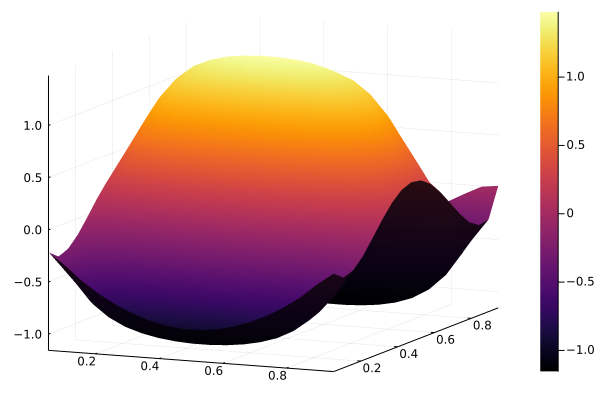

In [13]:
reference_v = vcat(true_v1.(I_points[1,:],I_points[2,:]),true_v2.(I_points[1,:],I_points[2,:]))

#N_I*2
#cond(Matrix(G))
G = sparse(G)
#display(reference_v)
sol = G\Global_RHS
err = abs.(sol - reference_v)
println("max error: ",maximum(err))
#surface(I_points[1,:],I_points[2,:],reference_v[1:N_I])
surface(I_points[1,:],I_points[2,:],sol[1:N_I])
#surface(I_points[1,:],I_points[2,:],sol[1+N_I:end])
#surface(I_points[1,:],I_points[2,:],error[1:N_I])

(2, 324)0.052631578947368420.052631578947368420.052631578947368420.105263157894736840.052631578947368420.157894736842105250.052631578947368420.210526315789473670.052631578947368420.26315789473684210.052631578947368420.31578947368421050.052631578947368420.36842105263157890.052631578947368420.421052631578947350.052631578947368420.473684210526315760.052631578947368420.52631578947368420.052631578947368420.57894736842105270.052631578947368420.6315789473684210.052631578947368420.68421052631578950.052631578947368420.73684210526315790.052631578947368420.78947368421052630.052631578947368420.84210526315789470.052631578947368420.89473684210526320.052631578947368420.94736842105263150.105263157894736840.052631578947368420.105263157894736840.105263157894736840.105263157894736840.157894736842105250.105263157894736840.210526315789473670.105263157894736840.26315789473684210.105263157894736840.31578947368421050.105263157894736840.36842105263157890.105263157894736840.421052631578947350.105263157894736840

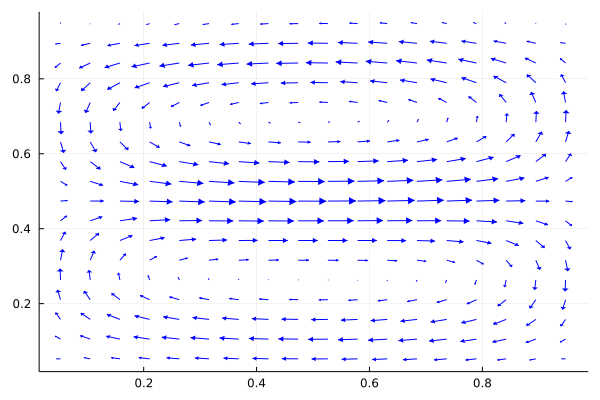

In [12]:
function plot_arrow!(x1,y1,x2,y2)
    color = :blue
    arr_width = 0.2
    vx = x2-x1
    vy = y2 -y1
    l_arr = sqrt(vx*vx+vy*vy)
    pqx= x1+3*(x2-x1)/4
    pqy= y1+3*(y2-y1)/4 # quarterpoint

    vpx = 1
    vpy = -vx/vy
    lp = sqrt(vpx*vpx + vpy*vpy)
    vpx = vpx/lp
    vpy = vpy/lp 

    p1ax = pqx + vpx*l_arr*arr_width
    p1ay = pqy + vpy*l_arr*arr_width

    p2ax = pqx - vpx*l_arr*arr_width
    p2ay = pqy - vpy*l_arr*arr_width

    plot!([x1,x2],[y1,y2],c=color,label = false) # line
    trian = Shape([(p1ax, p1ay),(p2ax,p2ay), (x2,y2), (p1ax, p1ay)])
    plot!(trian, c = color,label = false,linewidth = 0)
end

function visualize_vec_field(Points,u,v)
    scale = 0.05
    vel = sqrt.(u.^2 .+ v .^2)
    mx = maximum(vel)
    print(size(Points))
    plot()
    for i in 1:size(Points)[2]
        px,py = Points[:,i]
        print(px,py)
        #plot!([px,px+scale*u[i]/mx],[py,py+scale*v[i]/mx],label = false,arrow = arrow(),)
        plot_arrow!(px,py,px+scale*u[i]/mx,py+scale*v[i]/mx)
    end
    plot!()
end


visualize_vec_field(I_points,sol[1:N_I],sol[1+N_I:end])

In [ ]:
arrow(0.1)

Plots.Arrow(:simple, :head, 0.1, 0.1)